In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import quad
from qiskit.quantum_info.states import Statevector, DensityMatrix
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators import SuperOp, Choi, Kraus, PTM

from qiskit_dynamics import solve_ode, solve_lmde
from qiskit_dynamics.signals import Signal
from qiskit_dynamics.models import (HamiltonianModel, 
                                    LindbladModel, 
                                    rotating_wave_approximation)
from qiskit_dynamics import Solver


def gaussian(amp, sig, t0, t):
    return amp * np.exp( -(t - t0)**2 / (2 * sig**2) )

# Context

Qiskit Dynamics is a new package for simulating the physics of quantum systems (Hamiltonian and Lindbladian dynamics).
- First release in the next week or two.
- Establishes core structure for defining and numerically solving systems.

This demo:
- Walk through some of the core interfaces/functionality
- Note: the interfaces in this demo are now considered "lower level" interfaces


# In this demo

This notebook demonstrates some of the core model building and differential equation solving elements:
- Hamiltonian and signal construction
- Model transformations: entering a frame, making a rotating wave approximation
- Defining and solving differential equations

Sections
1. `Signal`s
2. Constructing a `HamiltonianModel`
3. Setting `frame` and `cutoff_freq` in `HamiltonianModel`
4. Integrating the Schrodinger equation
5. Adding dissipative dynamics with a `LindbladModel` and simulating density matrix evolution
6. Simulate the Lindbladian to get a `SuperOp` representation of the quantum channel

# 1. `Signal`

A `Signal` object represents a complex mixed signal, i.e. a function of the form: 
$$s(t) = Re[f(t)e^{i2 \pi \nu t}],$$
where $f(t)$ is the *envelope* and $\nu$ is the *carrier frequency*.

Here we define a signal with a Gaussian envelope:

In [2]:
amp = 1. # amplitude
sig = 2. # sigma
t0 = 3.5*sig # center of Gaussian
T = 7*sig # end of signal

gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)

gauss_signal = Signal(envelope=gaussian_envelope, carrier_freq=0.5)

In [3]:
print(gauss_signal.envelope(0.25))
print(gauss_signal(0.25))

0.0033616864879322562
0.0023770713118400873


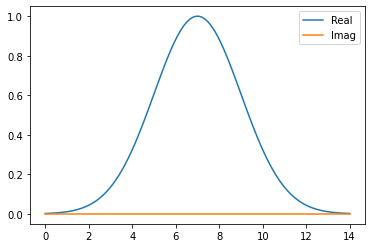

In [4]:
gauss_signal.draw(0, T, 100, function='envelope')

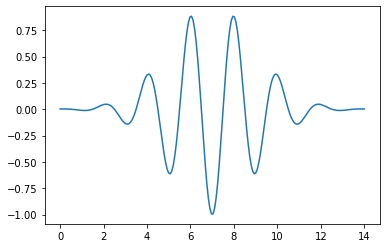

In [5]:
gauss_signal.draw(0, T, 200)

## 1.1 Other notes about signals in dynamics:
- `DiscreteSignal` represents a signal whose envelope is piecewise constant.
- Package has the beginnings of some signal processing elements, e.g. `Convolution` on `Signal`s
- Pulse schedule -> `DiscreteSignal` converter
- Can perform algebraic operations on signals, i.e. `sig1 + sig2`, `sig1 * sig2`.

# 2.(alternative) `Solver` class

This is the higher level `Solver` class. It combines model construction, transformations, and solving into one.

In [6]:
#####################
# construct operators
#####################
r = 0.1
w = 1.
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

###################
# construct signals
###################

# Define gaussian envelope function to have max amp and area approx 2 
amp = 1.
sig = 0.399128/r
t0 = 3.5*sig
T = 7*sig
gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)

signals = [Signal(envelope=gaussian_envelope, carrier_freq=w)]

#########################################
# construct solver with model information
#########################################

hamiltonian_solver = Solver(static_hamiltonian=drift, 
                            hamiltonian_operators=operators, 
                            hamiltonian_signals=signals)

# 2.1 Solving

Solve by calling the `solve` function. The interface mimicks the `scipy` `solve_ivp` interface, but provides access to other kinds of solvers too.

We will solve over the course of a $\pi$-pulse, and save the state over the period of points `t_eval`.

In [7]:
y0 = Statevector([0., 1.])
times = np.linspace(0., T, 500)
%time sol = hamiltonian_solver.solve(t_span=[0., T], y0=y0, t_eval=times)

CPU times: user 185 ms, sys: 2.96 ms, total: 188 ms
Wall time: 190 ms


In [8]:
# the output is a result object like `solve_ivp`, but contains formatting for qiskit types
sol.y[-1]

Statevector([0.19121535-0.98137932j, 0.00210751+0.01011345j],
            dims=(2,))


In [18]:
vals = [y.data[0] for y in sol.y]
print(vals)

[0j, (-1.5644903549440744e-08-3.842003558280952e-05j), (-7.074932688869228e-07-7.269025119278753e-05j), (-4.2646275867575555e-06-9.726130121227011e-05j), (-1.4046691035246844e-05-0.00010819298662586277j), (-3.359396217453483e-05-0.00010387316450991016j), (-6.521940264862123e-05-8.55028367302356e-05j), (-0.00010907369552317756-5.6439873169114825e-05j), (-0.0001625256381471007-2.0866529783395945e-05j), (-0.00021990597068706326+1.730351052328037e-05j), (-0.0002729090925059905+5.534502310428229e-05j), (-0.00031194915452725363+9.255831426477451e-05j), (-0.00032876701572636427+0.00013111374286245428j), (-0.00031935912983416996+0.0001761311751224818j), (-0.0002819968514750945+0.00023171307121631974j), (-0.00021962304501585872+0.00030039907857482603j), (-0.00013848732021257858+0.0003815184119969591j), (-4.619405161548185e-05+0.0004701360792577161j), (5.002388371449048e-05+0.0005568539823702484j), (0.00014493741453819304+0.0006287780607706788j), (0.0002369203306326305+0.000672024709891129j), (0

Text(0, 0.5, 'excited state population')

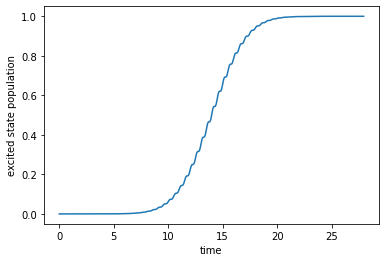

In [14]:
# plot the population in the excited state
pops = [np.abs(y.data[0])**2 for y in sol.y]
plt.plot(times, pops)
plt.xlabel("time")
plt.ylabel("excited state population")

Observe small ripples in the solution:

Text(0, 0.5, 'excited state population')

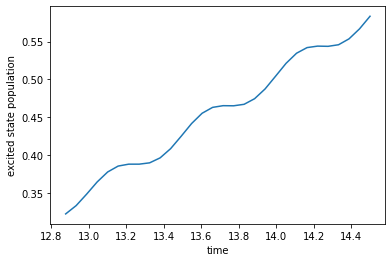

In [20]:
plt.plot(times[230:260], pops[230:260])
plt.xlabel("time")
plt.ylabel("excited state population")

These are due to driving on resonance: the control field needs to drive at the right time to ensure the state gets rotated.

# 2.2 Rotating frames and the rotating wave approximation

When constructing a solver, we can apply transformations to the model as well. (This is constructing a solver with the model in the rotating wave approximation section below.)

In [107]:
rwa_hamiltonian_solver = Solver(drift=drift, 
                                hamiltonian_operators=operators, 
                                hamiltonian_signals=signals, 
                                rotating_frame=drift,
                                rwa_cutoff_freq=2. * w)

We can solve over the same time period with this approximated model:

In [108]:
y0 = Statevector([0., 1.])
times = np.linspace(0., T, 500)
%time rwa_sol = rwa_hamiltonian_solver.solve(t_span=[0., T], y0=y0, t_eval=times, atol=1e-10, rtol=1e-10)

CPU times: user 165 ms, sys: 2.35 ms, total: 167 ms
Wall time: 166 ms


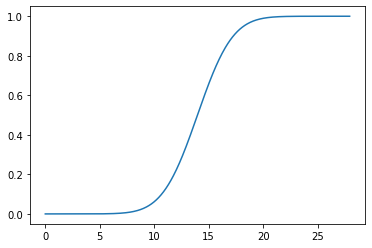

In [109]:
# plot the population in the excited state
rwa_pops = [np.abs(y.data[0])**2 for y in rwa_sol.y]
plt.plot(times, rwa_pops)

Observe that the solution is smooth compared to the unapproximated model:

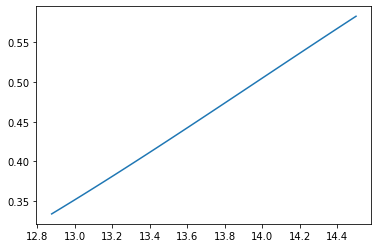

In [110]:
plt.plot(times[230:260], rwa_pops[230:260])

The effect of the RWA is to approximate the evolution with one that is more smooth. This produces a trade-off between solving time and accuracy:
- The smoother evolution is simpler and the solver can therefore take longer steps, as evidenced by the solver taking less time. However,
- As the RWA is an approximation, this comes at a cost to accuracy.

The final population in both simulations is:

In [111]:
print('Unapproximated population: ' + str(pops[-1]))
print('RWA population: ' + str(rwa_pops[-1]))

Unapproximated population: 0.9998904696792689
RWA population: 0.9999999999708551


Depending on the application, this discrepancy may be within acceptable tolerances, and therefore the approximation is worth doing.

# 2.3 Other things to potentially show with the `Solver` class

It does convenient handling of terra state and operator types. E.g. you can pass it a density matrix initial state and it will output the corresponding solutions as density matrices:

In [120]:
y0 = DensityMatrix([[0., 0.], [0., 1.]])
sol = hamiltonian_solver.solve(t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
sol.y[-1]

DensityMatrix([[ 9.99890470e-01+0.j        , -9.66489138e-03-0.00401347j],
               [-9.66489138e-03+0.00401347j,  1.09530092e-04+0.j        ]],
              dims=(2,))


You can pass a Super operator and it will construct the correct superoperator solution:

In [121]:
y0 = SuperOp(np.eye(4))
sol = hamiltonian_solver.solve(t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
sol.y[-1]

SuperOp([[ 1.09530092e-04+0.00000000e+00j,
           1.04645588e-02-1.05375375e-04j,
           1.04645588e-02+1.05375375e-04j,
           9.99890470e-01+0.00000000e+00j],
         [ 9.66489138e-03-4.01347347e-03j,
          -1.00726935e-04+4.30223829e-05j,
           9.27249708e-01-3.74150947e-01j,
          -9.66489138e-03+4.01347347e-03j],
         [ 9.66489138e-03+4.01347347e-03j,
           9.27249708e-01+3.74150947e-01j,
          -1.00726935e-04-4.30223829e-05j,
          -9.66489138e-03-4.01347347e-03j],
         [ 9.99890470e-01+0.00000000e+00j,
          -1.04645588e-02+1.05375375e-04j,
          -1.04645588e-02-1.05375375e-04j,
           1.09530092e-04+0.00000000e+00j]],
        input_dims=(2,), output_dims=(2,))

It provides a unified interface for Hamiltonian and Lindblad dynamics. This notebook originally worked directly with models,a nd there are separate model classes for Hamiltonians and the Lindblad equation (they are different mathematical equations so the code to evaluate them is a bit different). So, using the model classes, a user might have to construct different models and interact with them differently. The `Solver` however combines this into one: it will construct the right kind of model behind the scenes, and do all the initial state type handling (as in the previous examples) as appropriate depending onw hich model is stored internally.

In [122]:
lindblad_solver = Solver(drift=drift, 
                         hamiltonian_operators=operators, 
                         hamiltonian_signals=signals,
                         dissipator_operators=[0.01 * np.array([[0., 0.], [1., 0.]])])

In [123]:
y0 = DensityMatrix([[0., 0.], [0., 1.]])
sol = lindblad_solver.solve(t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
sol.y[-1]

DensityMatrix([[ 0.99863974+0.j        , -0.00950186-0.00439956j],
               [-0.00950186+0.00439956j,  0.00136026+0.j        ]],
              dims=(2,))


# 2. The `HamiltonianModel` class

A `HamiltonianModel` is specified as a list of Hermitian operators with `Signal` coefficients. Here, we use a classic qubit model:
$$H(t) = 2 \pi \nu \frac{Z}{2} + 2 \pi r s(t) \frac{X}{2}.$$

Generally, a `HamiltonianModel` represents a linear combination:
$$H(t) = H_d + \sum_j s_j(t) H_j,$$
where: 
 - $H_j$ are Hermitian operators given as `terra.quantum_info.Operator` objects, and 
 - $s_j(t) = Re[f_j(t)e^{i2 \pi \nu_j t}]$ specified as `Signal` objects.

Constructing a `HamiltonianModel` requires specifying lists of the operators and the signals.

In [6]:
#####################
# construct operators
#####################
r = 0.5
w = 1.
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

###################
# construct signals
###################

# Define gaussian envelope function to have max amp and area approx 2 
amp = 1.
sig = 0.399128/r
t0 = 3.5*sig
T = 7*sig
gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)

signals = [Signal(envelope=gaussian_envelope, carrier_freq=w)]

#################
# construct model
#################

hamiltonian = HamiltonianModel(drift=drift, operators=operators, signals=signals)

## 2.1 Evaluation and drift

Evaluate at a given time.

In [7]:
print(hamiltonian.evaluate(0.12))

[[0.-3.14159265j 0.-0.00419151j]
 [0.-0.00419151j 0.+3.14159265j]]


Get the drift (terms corresponding to constant coefficients).

In [8]:
hamiltonian.get_drift()

array([[ 3.14159265+0.j,  0.        +0.j],
       [ 0.        +0.j, -3.14159265+0.j]])

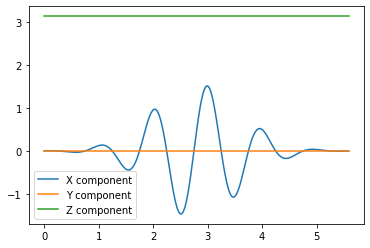

In [9]:
def plot_qubit_hamiltonian_components(hamiltonian, t0, tf, N=200):
    t_vals = np.linspace(t0, tf, N)
    model_vals = np.array([1j*hamiltonian.evaluate(t) for t in t_vals])
    x_coeff = model_vals[:, 0, 1].real
    y_coeff = -model_vals[:, 0, 1].imag
    z_coeff = model_vals[:, 0, 0].real
    plt.plot(t_vals, x_coeff, label='X component')
    plt.plot(t_vals, y_coeff, label='Y component')
    plt.plot(t_vals, z_coeff, label='Z component')
    plt.legend()

plot_qubit_hamiltonian_components(hamiltonian, 0., T)

## 2.2 Enter a rotating frame

We can specify a frame to enter the Hamiltonian in. Given a Hermitian operator $H_0$, *entering the frame* of $H_0$ means transforming a Hamiltonian $H(t)$:
$$H(t) \mapsto \tilde{H}(t) = e^{i H_0 t}H(t)e^{-iH_0 t} - H_0$$

Here, we will enter the frame of the drift Hamiltonian, resulting in:
$$\tilde{H}(t) = e^{i2 \pi \nu \frac{Z}{2} t}\left(2 \pi \nu \frac{Z}{2} + 2 \pi r s(t) \frac{X}{2}\right)e^{-i2 \pi \nu \frac{Z}{2} t} - 2 \pi \nu \frac{Z}{2} \\
                = 2 \pi r s(t) e^{i2 \pi \nu \frac{Z}{2} t}\frac{X}{2}e^{-i2 \pi \nu \frac{Z}{2} t}\\
                = 2 \pi r s(t) \left[\cos(2 \pi \nu t) \frac{X}{2} - \sin(2 \pi \nu t) \frac{Y}{2} \right]$$

In [10]:
hamiltonian.rotating_frame = hamiltonian.get_drift()

Evaluate again.

In [11]:
print(hamiltonian.evaluate(0.12))

[[ 0.        -0.j          0.00286929-0.00305548j]
 [-0.00286929-0.00305548j  0.        -0.j        ]]


In [ ]:
# validate with independent computation
t = 0.12
-1j*(2 * np.pi * r * np.real(signals[0](t)) * (np.cos(2*np.pi * w * t) * X / 2 
                                                - np.sin(2*np.pi * w * t) * Y / 2 ))

Replot the coefficients of the model in the Pauli basis over time.

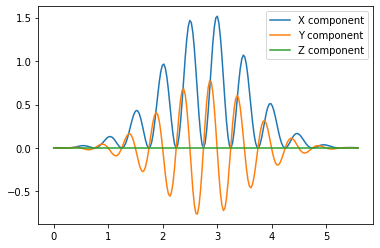

In [12]:
plot_qubit_hamiltonian_components(hamiltonian, 0., T)

# 3. Set cutoff frequency (rotating wave approximation)

A common technique to simplify the dynamics of a quantum system is to perform the *rotating wave approximation* (RWA), in which terms with high frequency are averaged to $0$.

The RWA can be applied on any `HamiltonianModel` (in the given `frame`) by setting the `cutoff_freq` attribute, which sets any fast oscillating terms to $0$, effectively performing a moving average on terms with carrier frequencies above `cutoff_freq`.

For our model, the classic `cutoff_freq` is $2 \nu$ (twice the qubit frequency). This approximates the Hamiltonian $\tilde{H}(t)$ as:
$$\tilde{H}(t) \approx 2 \pi \frac{r}{2} \left[Re[f(t)] \frac{X}{2} + Im[f(t)] \frac{Y}{2} \right],$$
where $f(t)$ is the envelope of the on-resonance drive. On our case $f(t) = Re[f(t)]$, and so we simply have
$$\tilde{H}(t) \approx 2 \pi \frac{r}{2} Re[f(t)] \frac{X}{2}.$$

In [13]:
# set the cutoff frequency
rwa_hamiltonian = rotating_wave_approximation(hamiltonian, 2*w)

In [14]:
# evaluate again
print(rwa_hamiltonian.evaluate(0.12))

[[ 0.00000000e+00-0.j         -6.50521303e-19-0.00287496j]
 [ 6.50521303e-19-0.00287496j  0.00000000e+00-0.j        ]]


We also plot the coefficients of the model in the frame of the drift with the RWA applied. We now expect to see simply a plot of $\pi \frac{r}{2} f(t)$ for the $X$ coefficient. 

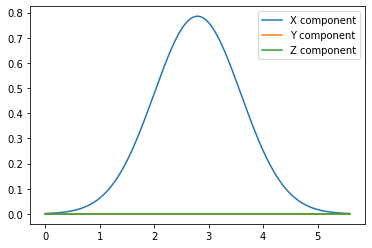

In [15]:
plot_qubit_hamiltonian_components(rwa_hamiltonian, 0., T)

# 4. Solve Schrodinger equation with a `HamiltonianModel`

To solve the Schrodinger Equation we call `solve_lmde`, which exposes an interface to different underlying solvers.

In [16]:
# solve the problem, with some options specified
y0 = Statevector([0., 1.])
%time sol = solve_lmde(hamiltonian, t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
y = sol.y[-1]
print("\nFinal state:")
print("----------------------------")
print(y)
print("\nPopulation in excited state:")
print("----------------------------")
print(np.abs(y[0])**2)

CPU times: user 330 ms, sys: 6.61 ms, total: 337 ms
Wall time: 334 ms

Final state:
----------------------------
[6.68006126e-06-0.99861417j 2.09958304e-03+0.05258639j]

Population in excited state:
----------------------------
0.9972302627366904


We can solve again using the Hamiltonian after doing the rotating wave approximation.

In [17]:
%time sol = solve_lmde(rwa_hamiltonian, t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
y = sol.y[-1]
print("\nFinal state:")
print("----------------------------")
print(y)
print("\nPopulation in excited state:")
print("----------------------------")
print(np.abs(y[0])**2)

CPU times: user 135 ms, sys: 3.27 ms, total: 138 ms
Wall time: 136 ms

Final state:
----------------------------
[-2.69626786e-15-1.00000000e+00j -8.67639175e-08-1.35240838e-15j]

Population in excited state:
----------------------------
0.9999999999756186


# 4.1 Technical solver notes:
- Behind the scenes, the `SchrodingerProblem` constructs an `OperatorModel` from the `HamiltonianModel`, representing the generator in the Schrodinger equation:
$$G(t) = \sum_j s_j(t)\left[-iH_j\right]$$
which is then pass used in a generalized routine for solving DEs of the form $y'(t) = G(t)y(t)$
- The generalized solver routine will automatically solve the DE in the drift frame, as well as in the basis in which the drift is diagonal (relevent for non-diagonal drift operators, to save on exponentiations for the frame operator).

# 5. Solving with dissipative dynamics 

To simulate with noise operators, we define a `LindbladModel`, containing:
- a model of a Hamiltonian (specified with either a `HamiltonianModel` object, or in the standard decomposition of operators and signals)
- an optional list of noise operators
- an optional list of time-dependent coefficients for the noise operators

Such a system is simulated in terms of the Lindblad master equation:
$$\dot{\rho}(t) = -i[H(t), \rho(t)] + \sum_j g_j(t) \left(L_j \rho L_j^\dagger - \frac{1}{2}\{L_j^\dagger L_j, \rho(t)\}\right),$$
where
- $H(t)$ is the Hamiltonian,
- $L_j$ are the noise operators, and
- $g_j(t)$ are the noise coefficients

Here we will construct such a model using the above `Hamitonian`, along with a noise operator that drives the state to the ground state.

In [ ]:
# construct quantum model with noise operators
noise_ops = [np.array([[0., 0.], 
                       [1., 0.]])]
noise_signals = [0.001]

lindblad_model = LindbladModel.from_hamiltonian(hamiltonian=hamiltonian, 
                                                dissipator_operators=noise_ops,
                                                dissipator_signals=noise_signals)

lindblad_model = LindbladModel(hamiltonian_operators=operators,
                               drift=drift,
                               rotating_frame=drift,
                               hamiltonian_signals=signals,
                               dissipator_operators=noise_ops,
                               dissipator_signals=noise_signals)



# density matrix
y0 = DensityMatrix([[0., 0.], [0., 1.]])

%time sol = solve_lmde(lindblad_model, t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
sol.y[-1]

We may also simulate the Lindblad equation with a cutoff frequency.

In [ ]:
rwa_lindblad_model = rotating_wave_approximation(lindblad_model, 2.0*w)
%time sol = solve_lmde(rwa_lindblad_model, t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
sol.y[-1]

## 5.1 Technical notes

- Similarly to the flow of `SchrodingerProblem`, `LindbladProblem` constructs an `OperatorModel` representing the *vectorized* Lindblad equation, which is then used to simulate the Lindblad equation on the vectorized density matrix.
- Frame handling and cutoff frequency handling are handled at the `OperatorModel` level, and hence can be used here as well.

## 5.2 Simulate the Lindbladian/SuperOp

In [ ]:
lindblad_model.evaluation_mode = 'dense_vectorized'
lindblad_model.rotating_frame = None

# identity quantum channel in superop representation
y0 = SuperOp(np.eye(4))

%time sol = solve_lmde(lindblad_model.__call__, t_span=[0., T], y0=y0, atol=1e-12, rtol=1e-12)
print(sol.y[-1])

In [ ]:
print(PTM(sol.y[-1]))

# 6. Other notes

- Everything above can be executed with JAX
   - Just-in-time compilation, automatic differentiation, GPU execution.
- Moved towards a higher level `Solver` interface
   - Combines model construction and solving into a single class interface.
   
Future additions:
- Model building tools
   - More concise operator construction/description.
   - Functions for building common models (e.g. coupled transmons).
- More pulse integration
   - Pulse schedule simulation
   - Pulse simulator
- Numerical methods research
   - MPO simulator
   - Perturbation theory (Dyson/Magnus) calculations and applications